Fatigue Detection using CNN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np 
import pandas as pd 
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.preprocessing import image

Mounted at /content/drive


In [ ]:
labels = os.listdir("/content/drive/MyDrive/image/train")
labels

['Open', 'Closed', 'yawn', 'no_yawn']

In [ ]:
def face_for_yawn(direc="/content/drive/MyDrive/image/train", face_cas_path="/content/drive/MyDrive/Face_detection/haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no


yawn_no_yawn = face_for_yawn()

0
1


In [ ]:
def get_data(dir_path="/content/drive/MyDrive/image/train", face_cas="/content/drive/MyDrive/Face_detection/haarcascade_frontalface_default.xml", eye_cas="/content/drive/MyDrive/Face_detection/haarcascade.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

data_train = get_data()

2
3


In [ ]:
def append_data():
#     total_data = []
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)
    return np.array(yaw_no)

new_data = append_data()

0
1
2
3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [ ]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

In [ ]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)
y = np.array(y)

In [ ]:
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [ ]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

In [ ]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 143, 143, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 71, 71, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 34, 34, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

In [ ]:
yawn_detector_model = model.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/50
43/43 [==============================] - 24s 281ms/step - loss: 1.1653 - accuracy: 0.4900 - val_loss: 0.8509 - val_accuracy: 0.7024
Epoch 2/50
43/43 [==============================] - 11s 261ms/step - loss: 0.5088 - accuracy: 0.7966 - val_loss: 0.3773 - val_accuracy: 0.8183
Epoch 3/50
43/43 [==============================] - 11s 260ms/step - loss: 0.4094 - accuracy: 0.8367 - val_loss: 0.2790 - val_accuracy: 0.8962
Epoch 4/50
43/43 [==============================] - 11s 260ms/step - loss: 0.3325 - accuracy: 0.8656 - val_loss: 0.3164 - val_accuracy: 0.8806
Epoch 5/50
43/43 [==============================] - 11s 261ms/step - loss: 0.3211 - accuracy: 0.8738 - val_loss: 0.2673 - val_accuracy: 0.8806
Epoch 6/50
43/43 [==============================] - 11s 258ms/step - loss: 0.2336 - accuracy: 0.9050 - val_loss: 0.2267 - val_accuracy: 0.9204
Epoch 7/50
43/43 [==============================] - 11s 259ms/step - loss: 0.2542 - accuracy: 0.8968 - val_loss: 0.2324 - val_accuracy: 0.9170

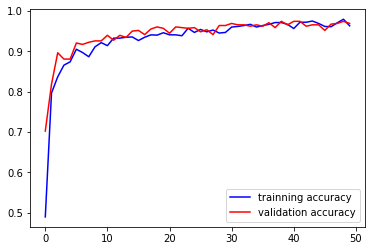

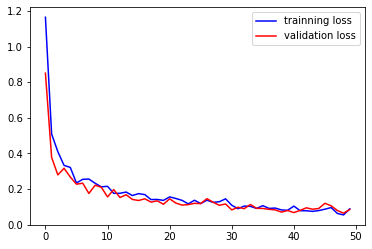

In [ ]:
accuracy = yawn_detector_model.history['accuracy']
val_accuracy = yawn_detector_model.history['val_accuracy']
loss = yawn_detector_model.history['loss']
val_loss = yawn_detector_model.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()


In [ ]:
model.save("detector.h5")
model.save("detector.model")

INFO:tensorflow:Assets written to: detector.model/assets


In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/detector.h5")

Image 1
No Yawn
Eyes Open


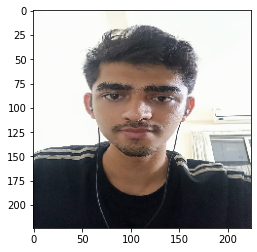

Image 2
Yawn
Eyes Open


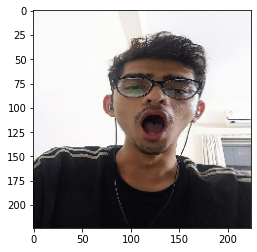

Image 3
No Yawn
Eyes Open


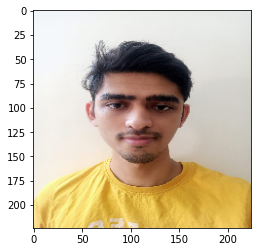

Result - The Person is not Fatigued


In [ ]:
fatigue_count, not_fatigue_count = 0,0 #Variable to count no. of fatigue and non fatigue features in images

face_cas_path="/content/drive/MyDrive/Face_detection/haarcascade_frontalface_default.xml"
eye_cas_path = "/content/drive/MyDrive/Face_detection/haarcascade_eye.xml"
dir_path = "/content/drive/MyDrive/image/ML_Assignment"
from tensorflow.keras.preprocessing import image
IMG_SIZE = 145
count  = 1
for i in os.listdir(dir_path):
    print(f"Image {count}")
    count += 1
    img = dir_path+"/"+i
    img1 = image.load_img(dir_path+"//"+i,target_size=(224,224))
    img_array = cv2.imread(img, cv2.IMREAD_COLOR)
    face_cascade = cv2.CascadeClassifier(face_cas_path)
    faces = face_cascade.detectMultiScale(img_array, 1.3, 5)
    for (x, y, w, h) in faces:
        img = cv2.rectangle(img_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
        roi_color = img[y:y+h, x:x+w]
        resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
    try:
        resized_array = resized_array / 255
    except:
        img_array = img_array/255
        resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    resized_array = resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
    x = model.predict(resized_array)
    val = np.argmax(x)
    if val==0:
      print("Yawn")
      yawn = 1
      
    else:
      print("No Yawn")
      yawn = 0
      

    img = dir_path+"/"+i
    img1 = image.load_img(dir_path+"//"+i,target_size=(224,224))
    img_array = cv2.imread(img, cv2.IMREAD_COLOR)
    eye_cascade = cv2.CascadeClassifier(eye_cas_path)
    eyes = eye_cascade.detectMultiScale(img_array, 1.3, 5)
    for (x, y, w, h) in eyes:
        img = cv2.rectangle(img_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
        roi_color = img[y:y+h, x:x+w]
        resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
    try:
        resized_array = resized_array / 255
    except:
        img_array = img_array/255
        resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    resized_array = resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
    x = model.predict(resized_array)
    val = np.argmax(x)
    if val==2:
      print("Eyes Closed")
      plt.imshow(img1)
      closed = 1
      plt.show()
    else:
      print("Eyes Open")
      closed = 0
      plt.imshow(img1)
      plt.show()

    if yawn + closed >= 1 :
      fatigue_count += 1
    else :
      not_fatigue_count += 1
if fatigue_count>not_fatigue_count:  #Final Result
  print("Result - The person is Fatigued")
else:
  print("Result - The Person is not Fatigued")